# Small data and deep learning
This pratical session proposes to study several techniques to improve training performance in the challenging context where few data and resources are available.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}_{\text{nolabel}}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |


If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset.)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


To run your experiments, you can use the same local installation as for previous TPs, or otherwise https://colab.research.google.com/.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader that will only use the first 100 samples of the CIFAR-10 training set. 

*Hint* : You can modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py or use the information from https://pytorch.org/vision/stable/datasets.html

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}_{\text{nolabel}}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [3]:

transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
nolabelset =  torch.utils.data.Subset(trainset, list(range(100, len(trainset))))
trainset = torch.utils.data.Subset(trainset, list(range(100)))
nolabel_dataloader = torch.utils.data.DataLoader(nolabelset, batch_size=batch_size, shuffle=True)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

len(train_dataloader), len(nolabel_dataloader), len(test_dataloader)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(10, 4990, 1000)

## Testing procedure
__Question 2 (1.5 points) :__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

__Answer:__

The evaluation of the training procedure is difficult since there is a risk of overfitting the training data after a few epochs of the training process. In particular, in this case we only have 100 training samples which make the risks for overfitting quite high.

A common method to evaluate the training procedure is to include a validation set in the training process on which we can evaluate the loss and/or accuracy of the model on samples that are out of the training set at each epoch. This way we can detect when the model  starts to overfit. However, in this case, we only have 100 training samples so we might not be able to afford cutting a validation set in the training set. We could still use the testing set to evaluate the model at each (few) epoch(s) but considering the size of our testing set, this might be too costly to use the whole testing set.

Another solution could be to use part of the unlabeled data. We could first apply an unsupervised learning method (such as clustering) on the training data mixed with part of the unlabeled data to infer some labels on the unlabeled data. Then, during the training on the training set, we could compare the model's predictions with the infered labels to see if they match. The problem with this method is that we the unsupervised learning could be very inaccurate and mess up the evaluation process.


# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ResNet-18 model, originally designed for the ImageNet dataset, can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

### ResNet model

In [4]:

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


### Training

In [5]:

model = ResNet18()
model.to(device)

epochs = 100
criterion = nn.CrossEntropyLoss()
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_update_period = 30
milestones = list(range(0, epochs, lr_update_period))[1:]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)


100%|██████████| 10/10 [00:00<00:00, 13.38it/s]


Train (epoch 1/100)	Loss: 18.150526	Accuracy: 10.00%


100%|██████████| 10/10 [00:00<00:00, 35.47it/s]


Train (epoch 2/100)	Loss: 3.707643	Accuracy: 13.00%


100%|██████████| 10/10 [00:00<00:00, 35.27it/s]


Train (epoch 3/100)	Loss: 2.245152	Accuracy: 13.00%


100%|██████████| 10/10 [00:00<00:00, 35.48it/s]


Train (epoch 4/100)	Loss: 2.248833	Accuracy: 19.00%


100%|██████████| 10/10 [00:00<00:00, 35.69it/s]


Train (epoch 5/100)	Loss: 2.251494	Accuracy: 15.00%


100%|██████████| 10/10 [00:00<00:00, 34.72it/s]


Train (epoch 6/100)	Loss: 2.230626	Accuracy: 16.00%


100%|██████████| 10/10 [00:00<00:00, 35.68it/s]


Train (epoch 7/100)	Loss: 2.200322	Accuracy: 15.00%


100%|██████████| 10/10 [00:00<00:00, 35.41it/s]


Train (epoch 8/100)	Loss: 2.183170	Accuracy: 18.00%


100%|██████████| 10/10 [00:00<00:00, 35.94it/s]


Train (epoch 9/100)	Loss: 2.185340	Accuracy: 19.00%


100%|██████████| 10/10 [00:00<00:00, 35.66it/s]


Train (epoch 10/100)	Loss: 2.119273	Accuracy: 23.00%


100%|██████████| 10/10 [00:00<00:00, 35.92it/s]


Train (epoch 11/100)	Loss: 2.212894	Accuracy: 12.00%


100%|██████████| 10/10 [00:00<00:00, 35.89it/s]


Train (epoch 12/100)	Loss: 2.209644	Accuracy: 12.00%


100%|██████████| 10/10 [00:00<00:00, 35.90it/s]


Train (epoch 13/100)	Loss: 2.198893	Accuracy: 16.00%


100%|██████████| 10/10 [00:00<00:00, 35.31it/s]


Train (epoch 14/100)	Loss: 2.087222	Accuracy: 23.00%


100%|██████████| 10/10 [00:00<00:00, 35.94it/s]


Train (epoch 15/100)	Loss: 2.107882	Accuracy: 24.00%


100%|██████████| 10/10 [00:00<00:00, 35.62it/s]


Train (epoch 16/100)	Loss: 2.132218	Accuracy: 20.00%


100%|██████████| 10/10 [00:00<00:00, 35.80it/s]


Train (epoch 17/100)	Loss: 2.027732	Accuracy: 25.00%


100%|██████████| 10/10 [00:00<00:00, 35.80it/s]


Train (epoch 18/100)	Loss: 2.139407	Accuracy: 22.00%


100%|██████████| 10/10 [00:00<00:00, 36.22it/s]


Train (epoch 19/100)	Loss: 2.025830	Accuracy: 26.00%


100%|██████████| 10/10 [00:00<00:00, 35.92it/s]


Train (epoch 20/100)	Loss: 2.011097	Accuracy: 23.00%


100%|██████████| 10/10 [00:00<00:00, 35.17it/s]


Train (epoch 21/100)	Loss: 1.937363	Accuracy: 29.00%


100%|██████████| 10/10 [00:00<00:00, 35.87it/s]


Train (epoch 22/100)	Loss: 1.992001	Accuracy: 30.00%


100%|██████████| 10/10 [00:00<00:00, 36.11it/s]


Train (epoch 23/100)	Loss: 1.909931	Accuracy: 28.00%


100%|██████████| 10/10 [00:00<00:00, 35.90it/s]


Train (epoch 24/100)	Loss: 1.837696	Accuracy: 33.00%


100%|██████████| 10/10 [00:00<00:00, 36.03it/s]


Train (epoch 25/100)	Loss: 1.736677	Accuracy: 32.00%


100%|██████████| 10/10 [00:00<00:00, 35.91it/s]


Train (epoch 26/100)	Loss: 1.940716	Accuracy: 31.00%


100%|██████████| 10/10 [00:00<00:00, 35.85it/s]


Train (epoch 27/100)	Loss: 1.769979	Accuracy: 34.00%


100%|██████████| 10/10 [00:00<00:00, 35.61it/s]


Train (epoch 28/100)	Loss: 1.748695	Accuracy: 33.00%


100%|██████████| 10/10 [00:00<00:00, 35.78it/s]


Train (epoch 29/100)	Loss: 1.722028	Accuracy: 38.00%


100%|██████████| 10/10 [00:00<00:00, 35.95it/s]


Train (epoch 30/100)	Loss: 1.840957	Accuracy: 33.00%


100%|██████████| 10/10 [00:00<00:00, 36.13it/s]


Train (epoch 31/100)	Loss: 1.619746	Accuracy: 39.00%


100%|██████████| 10/10 [00:00<00:00, 35.30it/s]


Train (epoch 32/100)	Loss: 1.560838	Accuracy: 52.00%


100%|██████████| 10/10 [00:00<00:00, 35.71it/s]


Train (epoch 33/100)	Loss: 1.521288	Accuracy: 45.00%


100%|██████████| 10/10 [00:00<00:00, 35.67it/s]


Train (epoch 34/100)	Loss: 1.410522	Accuracy: 48.00%


100%|██████████| 10/10 [00:00<00:00, 34.43it/s]


Train (epoch 35/100)	Loss: 1.406701	Accuracy: 48.00%


100%|██████████| 10/10 [00:00<00:00, 35.99it/s]


Train (epoch 36/100)	Loss: 1.383565	Accuracy: 53.00%


100%|██████████| 10/10 [00:00<00:00, 36.14it/s]


Train (epoch 37/100)	Loss: 1.403505	Accuracy: 50.00%


100%|██████████| 10/10 [00:00<00:00, 35.82it/s]


Train (epoch 38/100)	Loss: 1.413972	Accuracy: 56.00%


100%|██████████| 10/10 [00:00<00:00, 35.98it/s]


Train (epoch 39/100)	Loss: 1.330815	Accuracy: 55.00%


100%|██████████| 10/10 [00:00<00:00, 35.08it/s]


Train (epoch 40/100)	Loss: 1.291008	Accuracy: 56.00%


100%|██████████| 10/10 [00:00<00:00, 36.10it/s]


Train (epoch 41/100)	Loss: 1.284729	Accuracy: 61.00%


100%|██████████| 10/10 [00:00<00:00, 35.55it/s]


Train (epoch 42/100)	Loss: 1.220278	Accuracy: 57.00%


100%|██████████| 10/10 [00:00<00:00, 35.26it/s]


Train (epoch 43/100)	Loss: 1.288513	Accuracy: 53.00%


100%|██████████| 10/10 [00:00<00:00, 33.51it/s]


Train (epoch 44/100)	Loss: 1.325621	Accuracy: 53.00%


100%|██████████| 10/10 [00:00<00:00, 35.91it/s]


Train (epoch 45/100)	Loss: 1.144556	Accuracy: 62.00%


100%|██████████| 10/10 [00:00<00:00, 35.61it/s]


Train (epoch 46/100)	Loss: 1.143477	Accuracy: 60.00%


100%|██████████| 10/10 [00:00<00:00, 36.16it/s]


Train (epoch 47/100)	Loss: 1.136851	Accuracy: 58.00%


100%|██████████| 10/10 [00:00<00:00, 35.89it/s]


Train (epoch 48/100)	Loss: 1.095100	Accuracy: 64.00%


100%|██████████| 10/10 [00:00<00:00, 35.58it/s]


Train (epoch 49/100)	Loss: 1.065722	Accuracy: 69.00%


100%|██████████| 10/10 [00:00<00:00, 35.12it/s]


Train (epoch 50/100)	Loss: 1.201952	Accuracy: 60.00%


100%|██████████| 10/10 [00:00<00:00, 35.90it/s]


Train (epoch 51/100)	Loss: 1.026098	Accuracy: 64.00%


100%|██████████| 10/10 [00:00<00:00, 35.42it/s]


Train (epoch 52/100)	Loss: 1.067417	Accuracy: 69.00%


100%|██████████| 10/10 [00:00<00:00, 35.46it/s]


Train (epoch 53/100)	Loss: 1.027037	Accuracy: 71.00%


100%|██████████| 10/10 [00:00<00:00, 35.41it/s]


Train (epoch 54/100)	Loss: 0.955285	Accuracy: 68.00%


100%|██████████| 10/10 [00:00<00:00, 35.40it/s]


Train (epoch 55/100)	Loss: 0.983840	Accuracy: 70.00%


100%|██████████| 10/10 [00:00<00:00, 35.63it/s]


Train (epoch 56/100)	Loss: 0.914730	Accuracy: 67.00%


100%|██████████| 10/10 [00:00<00:00, 35.98it/s]


Train (epoch 57/100)	Loss: 0.822965	Accuracy: 78.00%


100%|██████████| 10/10 [00:00<00:00, 35.54it/s]


Train (epoch 58/100)	Loss: 0.975252	Accuracy: 68.00%


100%|██████████| 10/10 [00:00<00:00, 35.72it/s]


Train (epoch 59/100)	Loss: 1.008125	Accuracy: 58.00%


100%|██████████| 10/10 [00:00<00:00, 35.76it/s]


Train (epoch 60/100)	Loss: 0.778684	Accuracy: 73.00%


100%|██████████| 10/10 [00:00<00:00, 35.62it/s]


Train (epoch 61/100)	Loss: 0.691066	Accuracy: 79.00%


100%|██████████| 10/10 [00:00<00:00, 34.86it/s]


Train (epoch 62/100)	Loss: 0.682209	Accuracy: 79.00%


100%|██████████| 10/10 [00:00<00:00, 35.06it/s]


Train (epoch 63/100)	Loss: 0.706606	Accuracy: 79.00%


100%|██████████| 10/10 [00:00<00:00, 35.69it/s]


Train (epoch 64/100)	Loss: 0.704129	Accuracy: 79.00%


100%|██████████| 10/10 [00:00<00:00, 34.60it/s]


Train (epoch 65/100)	Loss: 0.653723	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 18.79it/s]


Train (epoch 66/100)	Loss: 0.762412	Accuracy: 77.00%


100%|██████████| 10/10 [00:00<00:00, 34.68it/s]


Train (epoch 67/100)	Loss: 0.623982	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 27.74it/s]


Train (epoch 68/100)	Loss: 0.616631	Accuracy: 82.00%


100%|██████████| 10/10 [00:00<00:00, 22.71it/s]


Train (epoch 69/100)	Loss: 0.608383	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 35.47it/s]


Train (epoch 70/100)	Loss: 0.615261	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 20.51it/s]


Train (epoch 71/100)	Loss: 0.560783	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 33.28it/s]


Train (epoch 72/100)	Loss: 0.606785	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 34.46it/s]


Train (epoch 73/100)	Loss: 0.644840	Accuracy: 81.00%


100%|██████████| 10/10 [00:00<00:00, 35.42it/s]


Train (epoch 74/100)	Loss: 0.571146	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 35.44it/s]


Train (epoch 75/100)	Loss: 0.555014	Accuracy: 87.00%


100%|██████████| 10/10 [00:00<00:00, 34.60it/s]


Train (epoch 76/100)	Loss: 0.622484	Accuracy: 80.00%


100%|██████████| 10/10 [00:00<00:00, 35.18it/s]


Train (epoch 77/100)	Loss: 0.557923	Accuracy: 84.00%


100%|██████████| 10/10 [00:00<00:00, 35.32it/s]


Train (epoch 78/100)	Loss: 0.538810	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 35.26it/s]


Train (epoch 79/100)	Loss: 0.589734	Accuracy: 82.00%


100%|██████████| 10/10 [00:00<00:00, 35.60it/s]


Train (epoch 80/100)	Loss: 0.575853	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 35.11it/s]


Train (epoch 81/100)	Loss: 0.592457	Accuracy: 81.00%


100%|██████████| 10/10 [00:00<00:00, 35.64it/s]


Train (epoch 82/100)	Loss: 0.658021	Accuracy: 82.00%


100%|██████████| 10/10 [00:00<00:00, 35.11it/s]


Train (epoch 83/100)	Loss: 0.542999	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 35.07it/s]


Train (epoch 84/100)	Loss: 0.552261	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 35.35it/s]


Train (epoch 85/100)	Loss: 0.542701	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 34.88it/s]


Train (epoch 86/100)	Loss: 0.525115	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 35.02it/s]


Train (epoch 87/100)	Loss: 0.505061	Accuracy: 86.00%


100%|██████████| 10/10 [00:00<00:00, 34.57it/s]


Train (epoch 88/100)	Loss: 0.532489	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 35.29it/s]


Train (epoch 89/100)	Loss: 0.513646	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 35.10it/s]


Train (epoch 90/100)	Loss: 0.519113	Accuracy: 88.00%


100%|██████████| 10/10 [00:00<00:00, 35.49it/s]


Train (epoch 91/100)	Loss: 0.488698	Accuracy: 87.00%


100%|██████████| 10/10 [00:00<00:00, 35.27it/s]


Train (epoch 92/100)	Loss: 0.492656	Accuracy: 86.00%


100%|██████████| 10/10 [00:00<00:00, 35.38it/s]


Train (epoch 93/100)	Loss: 0.466300	Accuracy: 88.00%


100%|██████████| 10/10 [00:00<00:00, 35.10it/s]


Train (epoch 94/100)	Loss: 0.529116	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 35.21it/s]


Train (epoch 95/100)	Loss: 0.556162	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 35.30it/s]


Train (epoch 96/100)	Loss: 0.474984	Accuracy: 87.00%


100%|██████████| 10/10 [00:00<00:00, 35.06it/s]


Train (epoch 97/100)	Loss: 0.638025	Accuracy: 76.00%


100%|██████████| 10/10 [00:00<00:00, 35.51it/s]


Train (epoch 98/100)	Loss: 0.506970	Accuracy: 86.00%


100%|██████████| 10/10 [00:00<00:00, 34.60it/s]


Train (epoch 99/100)	Loss: 0.477093	Accuracy: 88.00%


100%|██████████| 10/10 [00:00<00:00, 34.88it/s]


Train (epoch 100/100)	Loss: 0.584160	Accuracy: 80.00%

Train loss: 0.584160	Train accuracy: 80.00%


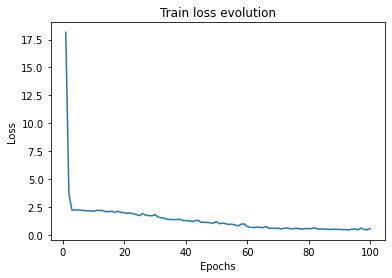

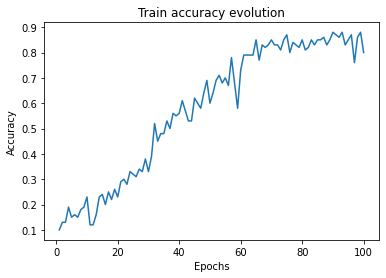

In [6]:

def train(model, train_dataloader, criterion, optimizer, scheduler):
    total_train_losses = []
    total_train_accs = []

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []
        
        correct = 0
        for i, batch, in enumerate(tqdm(train_dataloader)):
            img_batch, lbl_batch = batch
            img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(img_batch)
            loss = criterion(torch.flatten(outputs, 1), lbl_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            correct += (torch.flatten(outputs, 1).argmax(1) == lbl_batch).float().sum().cpu()
            
        print('Train (epoch {}/{})\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
            epoch, epochs, np.mean(train_losses), 100 * correct / len(trainset)))
                
        train_loss_mean = np.mean(train_losses)
        total_train_losses.append(train_loss_mean)
        train_acc_mean = correct / len(trainset)
        total_train_accs.append(train_acc_mean)

        scheduler.step()

    train_loss = total_train_losses[-1]
    train_acc = total_train_accs[-1]
    print("\nTrain loss: {:.6f}\tTrain accuracy: {:.2f}%".format(train_loss, train_acc * 100))

    plt.plot(list(range(epochs+1))[1:], total_train_losses)
    plt.title('Train loss evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

    plt.plot(list(range(epochs+1))[1:], total_train_accs)
    plt.title('Train accuracy evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

train(model, train_dataloader, criterion, optimizer, scheduler)


### Testing

In [7]:

def test(model, test_dataloader):
    model.eval()
    test_losses = []
    correct = 0

    for i, batch, in enumerate(tqdm(test_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)
        
        outputs = model(img_batch)
        loss = criterion(torch.flatten(outputs, 1), lbl_batch)
        
        test_losses.append(loss.item())
        correct += (torch.flatten(outputs, 1).argmax(1) == lbl_batch).float().sum().cpu()

    test_loss = np.mean(test_losses)
    test_acc = correct / len(testset)

    print("\nTest loss: {:.6f}\tTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

test(model, test_dataloader)


100%|██████████| 1000/1000 [00:08<00:00, 117.50it/s]


Test loss: 3.735729	Test accuracy: 17.82%


### Results


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 100 | 0.64 | 0.1782 |

# Transfer learning

We propose to use pre-trained models on a classification task, in order to improve the results of our setting.

## ImageNet features

Now, we will use a model pre-trained on ImageNet and see how well it performs on CIFAR. A list of ImageNet pre-trained models is available on : https://pytorch.org/vision/stable/models.html

__Question 4 (3 points) :__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

### Training

In [8]:

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.to(device)

epochs = 100
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_update_period = 30
milestones = list(range(0, epochs, lr_update_period))[1:]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

100%|██████████| 10/10 [00:00<00:00, 35.37it/s]


Train (epoch 1/100)	Loss: 2.625894	Accuracy: 19.00%


100%|██████████| 10/10 [00:00<00:00, 51.06it/s]


Train (epoch 2/100)	Loss: 1.928716	Accuracy: 46.00%


100%|██████████| 10/10 [00:00<00:00, 57.99it/s]


Train (epoch 3/100)	Loss: 1.501526	Accuracy: 57.00%


100%|██████████| 10/10 [00:00<00:00, 55.55it/s]


Train (epoch 4/100)	Loss: 1.091689	Accuracy: 62.00%


100%|██████████| 10/10 [00:00<00:00, 56.88it/s]


Train (epoch 5/100)	Loss: 0.959337	Accuracy: 75.00%


100%|██████████| 10/10 [00:00<00:00, 55.26it/s]


Train (epoch 6/100)	Loss: 0.930994	Accuracy: 73.00%


100%|██████████| 10/10 [00:00<00:00, 54.86it/s]


Train (epoch 7/100)	Loss: 0.647638	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 56.61it/s]


Train (epoch 8/100)	Loss: 0.498297	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 54.79it/s]


Train (epoch 9/100)	Loss: 0.719207	Accuracy: 81.00%


100%|██████████| 10/10 [00:00<00:00, 58.34it/s]


Train (epoch 10/100)	Loss: 0.751228	Accuracy: 78.00%


100%|██████████| 10/10 [00:00<00:00, 58.29it/s]


Train (epoch 11/100)	Loss: 0.559340	Accuracy: 81.00%


100%|██████████| 10/10 [00:00<00:00, 55.77it/s]


Train (epoch 12/100)	Loss: 0.706941	Accuracy: 80.00%


100%|██████████| 10/10 [00:00<00:00, 47.38it/s]


Train (epoch 13/100)	Loss: 0.638807	Accuracy: 82.00%


100%|██████████| 10/10 [00:00<00:00, 26.39it/s]


Train (epoch 14/100)	Loss: 0.513541	Accuracy: 83.00%


100%|██████████| 10/10 [00:00<00:00, 34.35it/s]


Train (epoch 15/100)	Loss: 0.523960	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 57.27it/s]


Train (epoch 16/100)	Loss: 0.571406	Accuracy: 82.00%


100%|██████████| 10/10 [00:00<00:00, 56.04it/s]


Train (epoch 17/100)	Loss: 0.415814	Accuracy: 89.00%


100%|██████████| 10/10 [00:00<00:00, 56.66it/s]


Train (epoch 18/100)	Loss: 0.760816	Accuracy: 80.00%


100%|██████████| 10/10 [00:00<00:00, 56.79it/s]


Train (epoch 19/100)	Loss: 0.546260	Accuracy: 82.00%


100%|██████████| 10/10 [00:00<00:00, 56.66it/s]


Train (epoch 20/100)	Loss: 0.496154	Accuracy: 86.00%


100%|██████████| 10/10 [00:00<00:00, 57.20it/s]


Train (epoch 21/100)	Loss: 0.537358	Accuracy: 86.00%


100%|██████████| 10/10 [00:00<00:00, 54.96it/s]


Train (epoch 22/100)	Loss: 0.463047	Accuracy: 85.00%


100%|██████████| 10/10 [00:00<00:00, 54.58it/s]


Train (epoch 23/100)	Loss: 0.513610	Accuracy: 84.00%


100%|██████████| 10/10 [00:00<00:00, 55.73it/s]


Train (epoch 24/100)	Loss: 0.524514	Accuracy: 82.00%


100%|██████████| 10/10 [00:00<00:00, 56.50it/s]


Train (epoch 25/100)	Loss: 0.482695	Accuracy: 88.00%


100%|██████████| 10/10 [00:00<00:00, 56.66it/s]


Train (epoch 26/100)	Loss: 0.479593	Accuracy: 89.00%


100%|██████████| 10/10 [00:00<00:00, 57.98it/s]


Train (epoch 27/100)	Loss: 0.437007	Accuracy: 84.00%


100%|██████████| 10/10 [00:00<00:00, 55.08it/s]


Train (epoch 28/100)	Loss: 0.278236	Accuracy: 90.00%


100%|██████████| 10/10 [00:00<00:00, 55.04it/s]


Train (epoch 29/100)	Loss: 0.298212	Accuracy: 95.00%


100%|██████████| 10/10 [00:00<00:00, 55.82it/s]


Train (epoch 30/100)	Loss: 0.276070	Accuracy: 91.00%


100%|██████████| 10/10 [00:00<00:00, 56.85it/s]


Train (epoch 31/100)	Loss: 0.210922	Accuracy: 93.00%


100%|██████████| 10/10 [00:00<00:00, 57.08it/s]


Train (epoch 32/100)	Loss: 0.246839	Accuracy: 93.00%


100%|██████████| 10/10 [00:00<00:00, 55.78it/s]


Train (epoch 33/100)	Loss: 0.156377	Accuracy: 93.00%


100%|██████████| 10/10 [00:00<00:00, 56.60it/s]


Train (epoch 34/100)	Loss: 0.116697	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 54.16it/s]


Train (epoch 35/100)	Loss: 0.117349	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 57.04it/s]


Train (epoch 36/100)	Loss: 0.091655	Accuracy: 96.00%


100%|██████████| 10/10 [00:00<00:00, 57.64it/s]


Train (epoch 37/100)	Loss: 0.109603	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 55.35it/s]


Train (epoch 38/100)	Loss: 0.090867	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 57.14it/s]


Train (epoch 39/100)	Loss: 0.098819	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 55.79it/s]


Train (epoch 40/100)	Loss: 0.086591	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 56.72it/s]


Train (epoch 41/100)	Loss: 0.121714	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 55.99it/s]


Train (epoch 42/100)	Loss: 0.052490	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 57.14it/s]


Train (epoch 43/100)	Loss: 0.088895	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 57.08it/s]


Train (epoch 44/100)	Loss: 0.061194	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 54.32it/s]


Train (epoch 45/100)	Loss: 0.061690	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 56.77it/s]


Train (epoch 46/100)	Loss: 0.034761	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 56.98it/s]


Train (epoch 47/100)	Loss: 0.038815	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 58.21it/s]


Train (epoch 48/100)	Loss: 0.120820	Accuracy: 95.00%


100%|██████████| 10/10 [00:00<00:00, 54.89it/s]


Train (epoch 49/100)	Loss: 0.076806	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 53.82it/s]


Train (epoch 50/100)	Loss: 0.070067	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 56.48it/s]


Train (epoch 51/100)	Loss: 0.036141	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 57.54it/s]


Train (epoch 52/100)	Loss: 0.091490	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 56.31it/s]


Train (epoch 53/100)	Loss: 0.084580	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 57.07it/s]


Train (epoch 54/100)	Loss: 0.026964	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 56.29it/s]


Train (epoch 55/100)	Loss: 0.073776	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 55.21it/s]


Train (epoch 56/100)	Loss: 0.086583	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 56.99it/s]


Train (epoch 57/100)	Loss: 0.052751	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 57.62it/s]


Train (epoch 58/100)	Loss: 0.056517	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 58.64it/s]


Train (epoch 59/100)	Loss: 0.068478	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 54.57it/s]


Train (epoch 60/100)	Loss: 0.027775	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 55.27it/s]


Train (epoch 61/100)	Loss: 0.019456	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 55.86it/s]


Train (epoch 62/100)	Loss: 0.031600	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 56.10it/s]


Train (epoch 63/100)	Loss: 0.026995	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 57.34it/s]


Train (epoch 64/100)	Loss: 0.072093	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 57.61it/s]


Train (epoch 65/100)	Loss: 0.033061	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 57.48it/s]


Train (epoch 66/100)	Loss: 0.015978	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 56.10it/s]


Train (epoch 67/100)	Loss: 0.103753	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 56.36it/s]


Train (epoch 68/100)	Loss: 0.060207	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 57.85it/s]


Train (epoch 69/100)	Loss: 0.036147	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 58.38it/s]


Train (epoch 70/100)	Loss: 0.056102	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 57.63it/s]


Train (epoch 71/100)	Loss: 0.050174	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 56.23it/s]


Train (epoch 72/100)	Loss: 0.035894	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 57.92it/s]


Train (epoch 73/100)	Loss: 0.057470	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 57.69it/s]


Train (epoch 74/100)	Loss: 0.021839	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 56.51it/s]


Train (epoch 75/100)	Loss: 0.028207	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 57.65it/s]


Train (epoch 76/100)	Loss: 0.020133	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 56.48it/s]


Train (epoch 77/100)	Loss: 0.010682	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 56.50it/s]


Train (epoch 78/100)	Loss: 0.017716	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 55.67it/s]


Train (epoch 79/100)	Loss: 0.065013	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 57.28it/s]


Train (epoch 80/100)	Loss: 0.081891	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 56.23it/s]


Train (epoch 81/100)	Loss: 0.071507	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 56.92it/s]


Train (epoch 82/100)	Loss: 0.040838	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 55.01it/s]


Train (epoch 83/100)	Loss: 0.035002	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 56.61it/s]


Train (epoch 84/100)	Loss: 0.045628	Accuracy: 98.00%


100%|██████████| 10/10 [00:00<00:00, 56.13it/s]


Train (epoch 85/100)	Loss: 0.023263	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 57.41it/s]


Train (epoch 86/100)	Loss: 0.033960	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 55.02it/s]


Train (epoch 87/100)	Loss: 0.038980	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 57.07it/s]


Train (epoch 88/100)	Loss: 0.039232	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 56.13it/s]


Train (epoch 89/100)	Loss: 0.129341	Accuracy: 96.00%


100%|██████████| 10/10 [00:00<00:00, 57.31it/s]


Train (epoch 90/100)	Loss: 0.023897	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 56.91it/s]


Train (epoch 91/100)	Loss: 0.022593	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 57.01it/s]


Train (epoch 92/100)	Loss: 0.029002	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 57.75it/s]


Train (epoch 93/100)	Loss: 0.030606	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 55.87it/s]


Train (epoch 94/100)	Loss: 0.024157	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 56.64it/s]


Train (epoch 95/100)	Loss: 0.051034	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 57.66it/s]


Train (epoch 96/100)	Loss: 0.069951	Accuracy: 97.00%


100%|██████████| 10/10 [00:00<00:00, 57.49it/s]


Train (epoch 97/100)	Loss: 0.038997	Accuracy: 99.00%


100%|██████████| 10/10 [00:00<00:00, 57.57it/s]


Train (epoch 98/100)	Loss: 0.023806	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 55.74it/s]


Train (epoch 99/100)	Loss: 0.018135	Accuracy: 100.00%


100%|██████████| 10/10 [00:00<00:00, 56.72it/s]


Train (epoch 100/100)	Loss: 0.032304	Accuracy: 99.00%

Train loss: 0.032304	Train accuracy: 99.00%


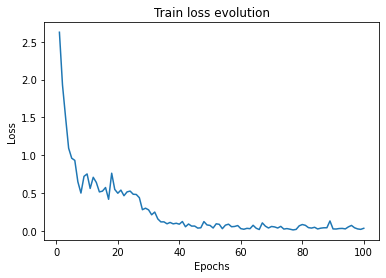

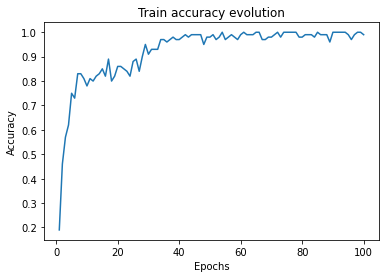

In [9]:

train(model, train_dataloader, criterion, optimizer, scheduler)


### Testing

In [10]:

test(model, test_dataloader)


100%|██████████| 1000/1000 [00:05<00:00, 171.17it/s]


Test loss: 2.603168	Test accuracy: 29.96%


### Results

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 100 | 0.64 | 0.1940 |
|   ResNet18 (transfer learning)  | 100 | 1.00 | 0.2996 |

# Incorporating priors
Geometrical priors are appealing for image classification tasks. 
A color image $x$ can be seen as a function: $\mathbb{S}\rightarrow\mathbb{R}^3$, where $\mathbb{S} \subset \mathbb{R}^2$ is the image support.
Let us consider transformations $\mathcal{T}$ of possible inputs $x$. For instance, if an image had infinite support, a translation $\mathcal{T}_a$ of an image $x$ by a shift $a$ would lead to a new infinite-support image $\mathcal{T}_a(x)$, described at each pixel $u$ by :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

__Answer:__

The problems with transformations such as translations, rotations, scaling effects or color changes on $32\times32$ images is that these transformations introduce some information loss while the original image does not carry much information to begin with. If we use these transformations, the image might be too distorted and the characteristics or the features in the image might not be usable for the model to learn.

To fix this, we could limit ourselves to small translations (or rotations, scaling effects, color changes) to make sure most of the charcteristics of the image are preserved. Otherwise, we could increase the image size using some interpolation method.

## Data augmentations

__Question 6 (3 points) :__ Propose a set of geometric transformations beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.
You can use tools from https://pytorch.org/vision/stable/transforms.html 

In [11]:

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainset = torch.utils.data.Subset(trainset, list(range(100)))
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

len(train_dataloader), len(test_dataloader)


Files already downloaded and verified
Files already downloaded and verified


(10, 1000)

### Training

In [12]:

model = ResNet18()
model.to(device)

epochs = 100
criterion = nn.CrossEntropyLoss()
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_update_period = 30
milestones = list(range(0, epochs, lr_update_period))[1:]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)


100%|██████████| 10/10 [00:00<00:00, 26.45it/s]


Train (epoch 1/100)	Loss: 17.315654	Accuracy: 20.00%


100%|██████████| 10/10 [00:00<00:00, 34.73it/s]


Train (epoch 2/100)	Loss: 3.106730	Accuracy: 12.00%


100%|██████████| 10/10 [00:00<00:00, 35.11it/s]


Train (epoch 3/100)	Loss: 2.358320	Accuracy: 18.00%


100%|██████████| 10/10 [00:00<00:00, 35.33it/s]


Train (epoch 4/100)	Loss: 2.288549	Accuracy: 12.00%


100%|██████████| 10/10 [00:00<00:00, 35.72it/s]


Train (epoch 5/100)	Loss: 2.200182	Accuracy: 16.00%


100%|██████████| 10/10 [00:00<00:00, 35.84it/s]


Train (epoch 6/100)	Loss: 2.204058	Accuracy: 17.00%


100%|██████████| 10/10 [00:00<00:00, 35.80it/s]


Train (epoch 7/100)	Loss: 2.234867	Accuracy: 17.00%


100%|██████████| 10/10 [00:00<00:00, 35.19it/s]


Train (epoch 8/100)	Loss: 2.187049	Accuracy: 16.00%


100%|██████████| 10/10 [00:00<00:00, 35.29it/s]


Train (epoch 9/100)	Loss: 2.167578	Accuracy: 17.00%


100%|██████████| 10/10 [00:00<00:00, 35.70it/s]


Train (epoch 10/100)	Loss: 2.126555	Accuracy: 18.00%


100%|██████████| 10/10 [00:00<00:00, 34.47it/s]


Train (epoch 11/100)	Loss: 2.150984	Accuracy: 19.00%


100%|██████████| 10/10 [00:00<00:00, 34.90it/s]


Train (epoch 12/100)	Loss: 2.104603	Accuracy: 20.00%


100%|██████████| 10/10 [00:00<00:00, 34.48it/s]


Train (epoch 13/100)	Loss: 2.127098	Accuracy: 14.00%


100%|██████████| 10/10 [00:00<00:00, 34.80it/s]


Train (epoch 14/100)	Loss: 2.153561	Accuracy: 19.00%


100%|██████████| 10/10 [00:00<00:00, 35.42it/s]


Train (epoch 15/100)	Loss: 2.140316	Accuracy: 22.00%


100%|██████████| 10/10 [00:00<00:00, 35.07it/s]


Train (epoch 16/100)	Loss: 2.090300	Accuracy: 23.00%


100%|██████████| 10/10 [00:00<00:00, 35.64it/s]


Train (epoch 17/100)	Loss: 2.044148	Accuracy: 21.00%


100%|██████████| 10/10 [00:00<00:00, 35.03it/s]


Train (epoch 18/100)	Loss: 2.029067	Accuracy: 22.00%


100%|██████████| 10/10 [00:00<00:00, 35.44it/s]


Train (epoch 19/100)	Loss: 2.102216	Accuracy: 22.00%


100%|██████████| 10/10 [00:00<00:00, 35.49it/s]


Train (epoch 20/100)	Loss: 2.052900	Accuracy: 17.00%


100%|██████████| 10/10 [00:00<00:00, 35.17it/s]


Train (epoch 21/100)	Loss: 2.042638	Accuracy: 21.00%


100%|██████████| 10/10 [00:00<00:00, 35.10it/s]


Train (epoch 22/100)	Loss: 2.004051	Accuracy: 23.00%


100%|██████████| 10/10 [00:00<00:00, 35.09it/s]


Train (epoch 23/100)	Loss: 1.914659	Accuracy: 30.00%


100%|██████████| 10/10 [00:00<00:00, 35.14it/s]


Train (epoch 24/100)	Loss: 1.920907	Accuracy: 29.00%


100%|██████████| 10/10 [00:00<00:00, 34.82it/s]


Train (epoch 25/100)	Loss: 1.843706	Accuracy: 28.00%


100%|██████████| 10/10 [00:00<00:00, 35.50it/s]


Train (epoch 26/100)	Loss: 1.850698	Accuracy: 35.00%


100%|██████████| 10/10 [00:00<00:00, 35.53it/s]


Train (epoch 27/100)	Loss: 1.797139	Accuracy: 37.00%


100%|██████████| 10/10 [00:00<00:00, 35.06it/s]


Train (epoch 28/100)	Loss: 1.752822	Accuracy: 34.00%


100%|██████████| 10/10 [00:00<00:00, 35.69it/s]


Train (epoch 29/100)	Loss: 1.872545	Accuracy: 28.00%


100%|██████████| 10/10 [00:00<00:00, 35.32it/s]


Train (epoch 30/100)	Loss: 1.776466	Accuracy: 34.00%


100%|██████████| 10/10 [00:00<00:00, 35.65it/s]


Train (epoch 31/100)	Loss: 1.711150	Accuracy: 35.00%


100%|██████████| 10/10 [00:00<00:00, 34.77it/s]


Train (epoch 32/100)	Loss: 1.654922	Accuracy: 37.00%


100%|██████████| 10/10 [00:00<00:00, 35.71it/s]


Train (epoch 33/100)	Loss: 1.651583	Accuracy: 42.00%


100%|██████████| 10/10 [00:00<00:00, 35.86it/s]


Train (epoch 34/100)	Loss: 1.611249	Accuracy: 41.00%


100%|██████████| 10/10 [00:00<00:00, 35.17it/s]


Train (epoch 35/100)	Loss: 1.557737	Accuracy: 36.00%


100%|██████████| 10/10 [00:00<00:00, 35.40it/s]


Train (epoch 36/100)	Loss: 1.529568	Accuracy: 47.00%


100%|██████████| 10/10 [00:00<00:00, 34.52it/s]


Train (epoch 37/100)	Loss: 1.507336	Accuracy: 42.00%


100%|██████████| 10/10 [00:00<00:00, 35.77it/s]


Train (epoch 38/100)	Loss: 1.505973	Accuracy: 45.00%


100%|██████████| 10/10 [00:00<00:00, 35.09it/s]


Train (epoch 39/100)	Loss: 1.528068	Accuracy: 43.00%


100%|██████████| 10/10 [00:00<00:00, 35.59it/s]


Train (epoch 40/100)	Loss: 1.535163	Accuracy: 50.00%


100%|██████████| 10/10 [00:00<00:00, 35.22it/s]


Train (epoch 41/100)	Loss: 1.569842	Accuracy: 46.00%


100%|██████████| 10/10 [00:00<00:00, 34.88it/s]


Train (epoch 42/100)	Loss: 1.509940	Accuracy: 44.00%


100%|██████████| 10/10 [00:00<00:00, 35.37it/s]


Train (epoch 43/100)	Loss: 1.481384	Accuracy: 46.00%


100%|██████████| 10/10 [00:00<00:00, 35.28it/s]


Train (epoch 44/100)	Loss: 1.465237	Accuracy: 50.00%


100%|██████████| 10/10 [00:00<00:00, 35.53it/s]


Train (epoch 45/100)	Loss: 1.451211	Accuracy: 49.00%


100%|██████████| 10/10 [00:00<00:00, 35.24it/s]


Train (epoch 46/100)	Loss: 1.446801	Accuracy: 47.00%


100%|██████████| 10/10 [00:00<00:00, 35.27it/s]


Train (epoch 47/100)	Loss: 1.459429	Accuracy: 45.00%


100%|██████████| 10/10 [00:00<00:00, 35.30it/s]


Train (epoch 48/100)	Loss: 1.447503	Accuracy: 50.00%


100%|██████████| 10/10 [00:00<00:00, 35.19it/s]


Train (epoch 49/100)	Loss: 1.350551	Accuracy: 47.00%


100%|██████████| 10/10 [00:00<00:00, 35.10it/s]


Train (epoch 50/100)	Loss: 1.376254	Accuracy: 53.00%


100%|██████████| 10/10 [00:00<00:00, 35.39it/s]


Train (epoch 51/100)	Loss: 1.363640	Accuracy: 47.00%


100%|██████████| 10/10 [00:00<00:00, 35.51it/s]


Train (epoch 52/100)	Loss: 1.359943	Accuracy: 55.00%


100%|██████████| 10/10 [00:00<00:00, 34.83it/s]


Train (epoch 53/100)	Loss: 1.370589	Accuracy: 52.00%


100%|██████████| 10/10 [00:00<00:00, 34.74it/s]


Train (epoch 54/100)	Loss: 1.338097	Accuracy: 53.00%


100%|██████████| 10/10 [00:00<00:00, 35.65it/s]


Train (epoch 55/100)	Loss: 1.419252	Accuracy: 53.00%


100%|██████████| 10/10 [00:00<00:00, 34.89it/s]


Train (epoch 56/100)	Loss: 1.309944	Accuracy: 55.00%


100%|██████████| 10/10 [00:00<00:00, 35.28it/s]


Train (epoch 57/100)	Loss: 1.308208	Accuracy: 56.00%


100%|██████████| 10/10 [00:00<00:00, 34.73it/s]


Train (epoch 58/100)	Loss: 1.294816	Accuracy: 52.00%


100%|██████████| 10/10 [00:00<00:00, 34.98it/s]


Train (epoch 59/100)	Loss: 1.289368	Accuracy: 57.00%


100%|██████████| 10/10 [00:00<00:00, 35.30it/s]


Train (epoch 60/100)	Loss: 1.235308	Accuracy: 58.00%


100%|██████████| 10/10 [00:00<00:00, 35.36it/s]


Train (epoch 61/100)	Loss: 1.179877	Accuracy: 60.00%


100%|██████████| 10/10 [00:00<00:00, 34.79it/s]


Train (epoch 62/100)	Loss: 1.327558	Accuracy: 59.00%


100%|██████████| 10/10 [00:00<00:00, 34.75it/s]


Train (epoch 63/100)	Loss: 1.150809	Accuracy: 58.00%


100%|██████████| 10/10 [00:00<00:00, 35.00it/s]


Train (epoch 64/100)	Loss: 1.174243	Accuracy: 59.00%


100%|██████████| 10/10 [00:00<00:00, 35.41it/s]


Train (epoch 65/100)	Loss: 1.130998	Accuracy: 63.00%


100%|██████████| 10/10 [00:00<00:00, 34.82it/s]


Train (epoch 66/100)	Loss: 1.208603	Accuracy: 59.00%


100%|██████████| 10/10 [00:00<00:00, 35.09it/s]


Train (epoch 67/100)	Loss: 1.167361	Accuracy: 60.00%


100%|██████████| 10/10 [00:00<00:00, 35.63it/s]


Train (epoch 68/100)	Loss: 1.114678	Accuracy: 64.00%


100%|██████████| 10/10 [00:00<00:00, 35.06it/s]


Train (epoch 69/100)	Loss: 1.170851	Accuracy: 62.00%


100%|██████████| 10/10 [00:00<00:00, 34.83it/s]


Train (epoch 70/100)	Loss: 1.136391	Accuracy: 62.00%


100%|██████████| 10/10 [00:00<00:00, 35.34it/s]


Train (epoch 71/100)	Loss: 1.142897	Accuracy: 64.00%


100%|██████████| 10/10 [00:00<00:00, 35.50it/s]


Train (epoch 72/100)	Loss: 1.189046	Accuracy: 59.00%


100%|██████████| 10/10 [00:00<00:00, 34.96it/s]


Train (epoch 73/100)	Loss: 1.164491	Accuracy: 60.00%


100%|██████████| 10/10 [00:00<00:00, 35.33it/s]


Train (epoch 74/100)	Loss: 1.139125	Accuracy: 59.00%


100%|██████████| 10/10 [00:00<00:00, 35.32it/s]


Train (epoch 75/100)	Loss: 1.115013	Accuracy: 60.00%


100%|██████████| 10/10 [00:00<00:00, 34.65it/s]


Train (epoch 76/100)	Loss: 1.094055	Accuracy: 58.00%


100%|██████████| 10/10 [00:00<00:00, 34.61it/s]


Train (epoch 77/100)	Loss: 1.136630	Accuracy: 63.00%


100%|██████████| 10/10 [00:00<00:00, 35.24it/s]


Train (epoch 78/100)	Loss: 1.100524	Accuracy: 61.00%


100%|██████████| 10/10 [00:00<00:00, 35.01it/s]


Train (epoch 79/100)	Loss: 1.116001	Accuracy: 62.00%


100%|██████████| 10/10 [00:00<00:00, 34.85it/s]


Train (epoch 80/100)	Loss: 1.129195	Accuracy: 60.00%


100%|██████████| 10/10 [00:00<00:00, 34.86it/s]


Train (epoch 81/100)	Loss: 1.049297	Accuracy: 68.00%


100%|██████████| 10/10 [00:00<00:00, 34.82it/s]


Train (epoch 82/100)	Loss: 1.080743	Accuracy: 64.00%


100%|██████████| 10/10 [00:00<00:00, 34.10it/s]


Train (epoch 83/100)	Loss: 1.058188	Accuracy: 64.00%


100%|██████████| 10/10 [00:00<00:00, 34.61it/s]


Train (epoch 84/100)	Loss: 1.119498	Accuracy: 58.00%


100%|██████████| 10/10 [00:00<00:00, 34.61it/s]


Train (epoch 85/100)	Loss: 1.180388	Accuracy: 59.00%


100%|██████████| 10/10 [00:00<00:00, 34.56it/s]


Train (epoch 86/100)	Loss: 1.215728	Accuracy: 63.00%


100%|██████████| 10/10 [00:00<00:00, 34.33it/s]


Train (epoch 87/100)	Loss: 0.997500	Accuracy: 65.00%


100%|██████████| 10/10 [00:00<00:00, 35.17it/s]


Train (epoch 88/100)	Loss: 1.184828	Accuracy: 61.00%


100%|██████████| 10/10 [00:00<00:00, 34.62it/s]


Train (epoch 89/100)	Loss: 1.065529	Accuracy: 62.00%


100%|██████████| 10/10 [00:00<00:00, 34.25it/s]


Train (epoch 90/100)	Loss: 1.117324	Accuracy: 62.00%


100%|██████████| 10/10 [00:00<00:00, 34.82it/s]


Train (epoch 91/100)	Loss: 1.225296	Accuracy: 62.00%


100%|██████████| 10/10 [00:00<00:00, 34.35it/s]


Train (epoch 92/100)	Loss: 1.038427	Accuracy: 67.00%


100%|██████████| 10/10 [00:00<00:00, 35.23it/s]


Train (epoch 93/100)	Loss: 1.113430	Accuracy: 62.00%


100%|██████████| 10/10 [00:00<00:00, 34.78it/s]


Train (epoch 94/100)	Loss: 1.072496	Accuracy: 65.00%


100%|██████████| 10/10 [00:00<00:00, 34.47it/s]


Train (epoch 95/100)	Loss: 1.066451	Accuracy: 67.00%


100%|██████████| 10/10 [00:00<00:00, 34.65it/s]


Train (epoch 96/100)	Loss: 1.088554	Accuracy: 63.00%


100%|██████████| 10/10 [00:00<00:00, 34.37it/s]


Train (epoch 97/100)	Loss: 1.203406	Accuracy: 60.00%


100%|██████████| 10/10 [00:00<00:00, 35.21it/s]


Train (epoch 98/100)	Loss: 1.126327	Accuracy: 62.00%


100%|██████████| 10/10 [00:00<00:00, 34.84it/s]


Train (epoch 99/100)	Loss: 1.143751	Accuracy: 63.00%


100%|██████████| 10/10 [00:00<00:00, 33.88it/s]


Train (epoch 100/100)	Loss: 1.364896	Accuracy: 53.00%

Train loss: 1.364896	Train accuracy: 53.00%


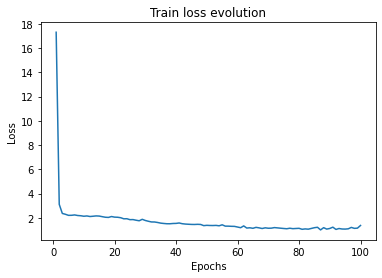

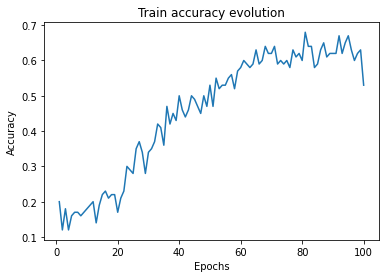

In [13]:

train(model, train_dataloader, criterion, optimizer, scheduler)


### Testing

In [15]:

test(model, test_dataloader)


100%|██████████| 1000/1000 [00:08<00:00, 115.61it/s]


Test loss: 3.140243	Test accuracy: 20.65%


### Results

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 100 | 0.64 | 0.1782 |
|   ResNet18 (transfer learning)  | 100 | 1.00 | 0.2996 |
|   ResNet18 (data augmentation)  | 100 | 0.80 | 0.2065 |

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

__Answer:__

In this notebook, we implemented three training methods on the CIFAR-10 dataset with very few (only 100) training samples while the testing set amounted for 10,000 samples. The accrucacies reached by each method are displayed in the following table:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 100 | 0.64 | 0.1782 |
|   ResNet18 (transfer learning)  | 100 | 1.00 | 0.2996 |
|   ResNet18 (data augmentation)  | 100 | 0.80 | 0.2065 |



### ResNet18 model trained from scratch

The first training method we implemented was training the ResNet18 model from scratch (i.e. from randomly initialized weights). This model reached a training accuracy of 64% after 100 epoch but its accuracy on the testing set was only 19.40%.

The advantages of this method are the following:
*   Does not use pre-trained weights so the model architecture is free to be outside of the typically trained models.

The drawbacks of this method are the following:
*   Easily overfits the training set, especially if there are few training samples. Here the training loss was 1.043173 in the end while the testing loss was 2.650611 (i.e. around 2.5 times higher) so we can guess that the overfitting started way before the 100th epoch;
*   As shown in the accuracy graph bellow, this method takes a longer time (high number of epochs) to reach a good accuracy. After 60 epochs, the loss is already quite lower than at the start but the accuracy is only around 50%.


Training loss and accuracy graphs:

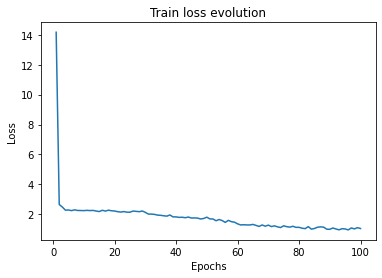
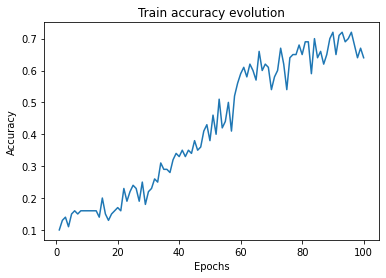


### ResNet18 model trained by transfer learning

The second training method we implemented was training the same model (ResNet18) by transfer learning using weights pre-trained on the ImageNet dataset. We choose to use this same model to be able to reliably compare the results of our experiments. With this method, the training accuracy after 100 epochs was 100% while the testing accuracy was 29.82%.

The advantages of this method are the following:
*   It reaches a good training accuracy after only a few epoch. As shown in the accuracy graph bellow, the model reaches a training accuracy over 80% after only 20 epochs and at the 40th epoch it reached 100% accuracy already;
*   It allows the model to reach lower loss since the basic image features are already knwon by the pre-trained model. The training loss ended up at 0.020519 which is 5 times lower than with the previous method.

The drawbacks of this method are the following:
*   This method is still subject to overfitting. We can see it in the clear gap in training and testing accuracies but also in the fact that the model reaches 100% training accuracy after 40 epochs. We need to carefully fine tune the learning rate and number of epochs in order to reduce this risk;
*   The architecture of the model in use has to be part of the typical models trained on ImageNet (or any other dataset). Many pre-trained models are available but it does not allow for unlimited freedom in the architecture of the model.


Training loss and accuracy graphs:

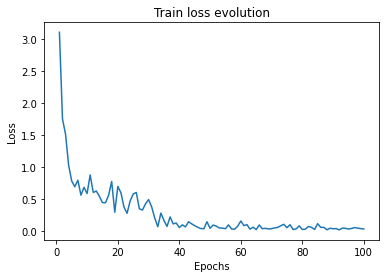
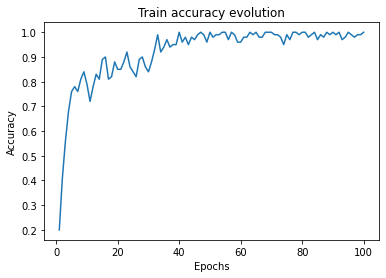


### ResNet18 model trained from scratch using data augmentation

The third and last training method we implemented was adding a data augmentation step in the first training method. We used an horizontal flip (no vertical flip to avoid upside down images), a random crop and a normalization of the pixel colors in a preprocessing pipeline. This method reached similar results to the first method with a training accuracy of 80% and a testing accuracy of 19.84%.

The advantages of this method are the following:
*   It can improve the performance of learning processes on small datasets by generating new labeled samples;
*   Does not use pre-trained weights so the model architecture is free to be outside of the typically trained models.

The drawbacks of this method are the following:
*   With small images such as the ones used here, many transformations are dangerous to use such as translations, rotations, scaling effects or color changes. Thus, the benfits of this method are limited here;
*   This method is also subject to overfitting. Here the model reached better training accuracy and loss (0.719964) than the first method but similar testing accuracy and poorer loss (3.474962). This shows that the data augmentation was not successful with only 100 samples of $32\times32$ images.


Training loss and accuracy graphs:

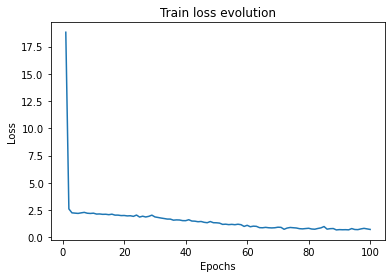
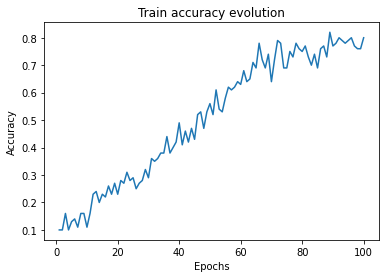

# Weak supervision

__Bonus \[open\] question (up to 4 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$ to train a model (a subset of $\mathcal{X}_{\text{nolabel}}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.